# 신용카드 사기 거래 예측(credit card analysis)

## 문제 상황  

카드사 A는 최근 비트코인 열풍으로 수수료 거래 금액이 늘어 좋으면서도  한 편으로 골치를 썩고 있다. 비트코인 결제를 신용카드로 결제하여 많은  
수수료를 얻어가고 있지만, 그만큼 사기거래가 발생하고 처리해달라는 고객 Claim이 수도 없이 쏟아지기 때문이다. 이에 카드사는 사기거래로  
예측되는 거래건에 경우 거래를 제한하고자 한다.

## 문제 해결 프로세스  

1. 문제정의

- 사기거래로 인한 고객 Claim 증가, 브랜드 이미지 감소, 고객 탈퇴

2. 기대효과

- 사기거래 거래 제한으로 고객 Claim 감소, 브랜드 이미지 회복, 고객 방어 

3. 해결방안

- 카드 Spending data 활용 사기거래 예측 

4. 성과측정

- 모델 적용 전/후 사기거래 Claim 감소 건수

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('C:/Users/USER/Desktop/Practice Project/신용카드 사기 거래 예측/신용카드 사기 거래 예측.csv')
df.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [6]:
df.isnull().sum()

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
cvv                      123
signature_image          105
transaction_type         116
transaction_env          123
EVENT_TIMESTAMP          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
EVENT_LABEL                0
dtype: int64

In [4]:
print("총 결측치 수: {} = 전체 데이터의 {:.2f}%".format(df.isnull().sum().sum(), (df.isnull().sum().sum()*100)/(df.shape[0]*df.shape[1])))

총 결측치 수: 3000 = 전체 데이터의 0.08%


#### 변수 해석 3가지  

1. 결측치 존재 여부

- 전체 데이터에서 EVENT_LABEL을 제외한 모든 변수에서 결측치가 존재한다.

- 결측치의 개수는 전체 1% 채 되지 않는 3000개이다.

- 결측치를 대체하는 경우, object형태는 최빈값으로 대체하고, float64형태는 평균으로 대체하거나 KNN을 사용할 수 있다.

- 하지만, 결측치의 개수가 전체 데이터에 비해 너무 적기 때문에 제거하는 것이 좋아보인다.

2. 데이터 타입 설명

- 종속변수는 object형태, 독립변수는 object, float64형태로 구성되어 있다. 독립변수 object타입은 인코딩을 통하여 변환해줄 필요가 있어보인다.  

3. 컬럼 설명

- account_age_days : 계좌 생성후 지난일
- transaction_amt : 거래금액
- transaction_adj_amt : 거래 조정 금액
- historic_velocity : 과거 거래금액
- ip_address : IP주소
- user_agent : 사용환경
- email_domain : email 도메인
- phone_number : 전화번호
- billing_city : 청구도시
- billing_postal : 청구우편번호
- billing_state : 청구주
- card_bin : 카드bin번호(앞6자리)
- currency : 통화
- cvv : CVV
- signature_image : 서명이미지
- transaction_type : 거래종류
- transaction_env : 거래환경
- EVENT_TIMESTAMP : 거래일자
- applicant_name : 이름
- billing_address : 청구주소
- merchant_id : 상점ID
- locale : 지역
- tranaction_initiate : 거래초기코드
- days_since_last_logon : 마지막 로그인 후 경과일
- inital_amount : 초기잔액
- EVENT_LABEL : 사기여부

In [2]:
df=df.dropna(axis=0)

결측치 데이터가 작아서 결측치 행을 모두 제거한다

In [8]:
df.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
count,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000
mean,4645.817224,2521.343592,54.208837,4702.388673,50179.458129,41834.312320,49.858524,7996.856367
std,1153.792072,604.680167,10.068128,1188.255402,28389.219411,10082.094148,29.208844,4047.922681
min,1.000000,5.000000,1.000000,50.000000,503.000000,6040.000000,0.000000,1000.000000
25%,3824.000000,2103.000000,48.000000,3872.000000,25298.000000,35386.000000,24.000000,4485.000000
50%,4668.000000,2543.000000,55.000000,4729.000000,50072.000000,42086.000000,50.000000,7999.000000
75%,5476.000000,2951.000000,61.000000,5548.000000,74346.000000,47373.000000,75.000000,11495.000000
max,9119.000000,4999.000000,99.000000,9999.000000,99950.000000,67639.000000,100.000000,15000.000000


우선 describe로 이상치를 판단하기 위해서는 mean, min, max 값을 확인하는 것이 좋다. mean과 min, mean과 max 값이 std에 비해 한참 차이가 난다면, 이상치가 있을 가능성이 높다. 이러한 이상치를 정확히 판단하기 위해서는 아래와 같이 boxplot으로 시각화하여 보는 것이 정확하다.

In [3]:
df_n = df.select_dtypes(exclude = 'object')

In [4]:
outlier = pd.melt(df_n, var_name = '이상치 탐색 변수', value_name = '이상치 탐색 값')
outlier

,이상치 탐색 변수,이상치 탐색 값
0,account_age_days,3371.0
1,account_age_days,2714.0
2,account_age_days,6987.0
3,account_age_days,2712.0
4,account_age_days,3598.0
...,...,...
1175995,inital_amount,6681.0
1175996,inital_amount,2402.0
1175997,inital_amount,4113.0
1175998,inital_amount,4531.0


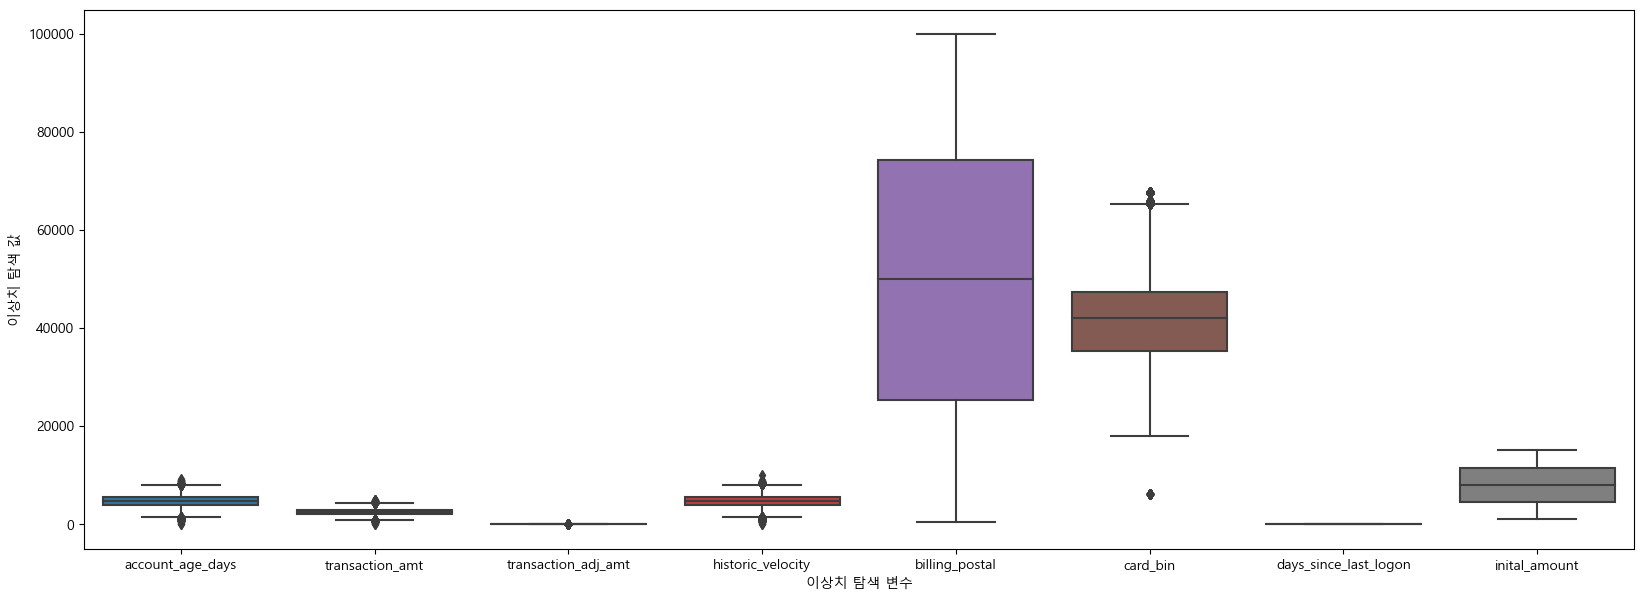

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (20,7))
sns.boxplot(x = '이상치 탐색 변수', y = '이상치 탐색 값', data = outlier)
plt.xticks(range(8), df_n.columns)
plt.show()

이상치를 탐색하기 위해서 수치형 변수들만 선택해서 boxplot으로 시각화하였다. 이상치의 값이 연속적으로 나타나면, 보통 의미있는 값일 확률이 높기 때문에 따로 제거하거나 대체하지 않고, 눈에 띄는 이상치가 있을 경우에는 보통 제거하거나 대체하는 경우가 많다.(예를 들어, Age 변수가 999값이 있으면 제거하거나 대체하는 것이 옳다.)

In [18]:
print(df['user_agent'].head(1))

0    Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...
Name: user_agent, dtype: object


In [6]:
df['user_agent'] = df['user_agent'].apply(lambda x: x.split('/')[0])

In [23]:
df.head(3)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit


user_agent 브라우저의 이름만 선택해서 변수명을 재설정한다. 뒤의 사양과 같은 특성들은 분석하는데 혼란을 줄 수 있기 때문이다

In [24]:
df['EVENT_LABEL'].value_counts()

legit    138996
fraud      8004
Name: EVENT_LABEL, dtype: int64

In [25]:
print("평균 사기 거래률 : ", (8004 / (8004 + 138996) ) * 100)

평균 사기 거래률 :  5.444897959183673


## 사기 거래 특성 파악(수치형 변수)

In [7]:
numeric_list=[]
categoical_list=[]

for i in df.columns :
    if df[i].dtypes == 'O' :
        categoical_list.append(i)
    else :
        numeric_list.append(i)

print("categoical_list :", categoical_list)
print("numeric_list :", numeric_list)

categoical_list : ['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate', 'EVENT_LABEL']
numeric_list : ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'billing_postal', 'card_bin', 'days_since_last_logon', 'inital_amount']


1. 수치형 변수(numeric_list)

- 연속형 변수는 구간화를 통해 범주형 변수로 변경하고, 잘 구분 되어지는지 확인

- 평균 사기거래률 대비 그룹핑한 그룹의 사기거래율이 차이가 나는 것  

2. 범주형 변수(categoical_list)

- 각 그룹별 예측하고자 하는 데이터가 잘 나눠지는지 확인

- 각 그룹마다 사기거래율의 차이가 나는 것

In [27]:
df[numeric_list]

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
0,3371.0,2167.0,56.0,2572.0,96336.0,40771.0,59.0,13646.0
1,2714.0,2045.0,48.0,4517.0,78083.0,24480.0,0.0,11930.0
2,6987.0,2892.0,61.0,5007.0,83236.0,37778.0,83.0,7412.0
3,2712.0,3040.0,28.0,6022.0,78364.0,55790.0,24.0,4623.0
4,3598.0,2976.0,66.0,2600.0,77499.0,37370.0,21.0,1905.0
...,...,...,...,...,...,...,...,...
149995,3986.0,2890.0,57.0,4544.0,34817.0,30017.0,99.0,6681.0
149996,5834.0,1875.0,61.0,4369.0,35879.0,65507.0,85.0,2402.0
149997,4781.0,3371.0,48.0,5135.0,84167.0,47079.0,22.0,4113.0
149998,6085.0,2306.0,59.0,4846.0,80391.0,25891.0,70.0,4531.0


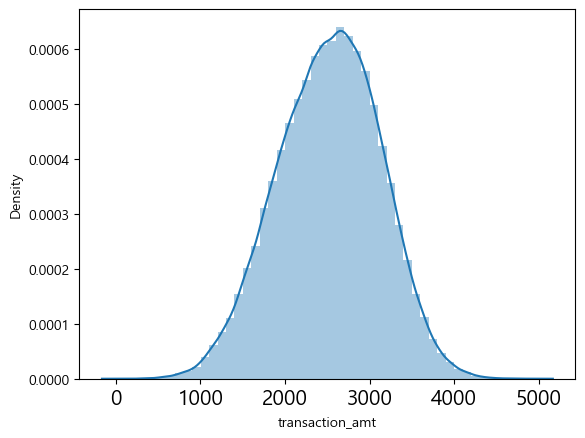

In [28]:
sns.distplot(df['transaction_amt']);

transaction_amt(거래 금액)의 분포를 확인한다. 한눈에 봐도 정규분포 형태를 띄고 있음을 알 수 있다

In [8]:
import numpy as np
df['transaction_amt_gp'] = np.where (df['transaction_amt'] <= 2000, 1, 
                           np.where(df['transaction_amt'] <= 3000, 2, 3))

df[['transaction_amt','transaction_amt_gp']]

,transaction_amt,transaction_amt_gp
0,2167.0,2
1,2045.0,2
2,2892.0,2
3,3040.0,3
4,2976.0,2
...,...,...
149995,2890.0,2
149996,1875.0,1
149997,3371.0,3
149998,2306.0,2


2000, 3000 사이의 값을 평균으로 측정하고 3개의 구간으로 구간화를 진행한다

In [9]:
df.groupby(['transaction_amt_gp', 'EVENT_LABEL'])['transaction_amt'].count()

transaction_amt_gp  EVENT_LABEL
1                   fraud            353
                    legit          29420
2                   fraud           4825
                    legit          79588
3                   fraud           2826
                    legit          29988
Name: transaction_amt, dtype: int64

In [10]:
print("gp1 :", (353 / (353+29420))*100)
print("gp2 :", (4825 / (4825+79588))*100)
print("gp3 :", (2826 / (2826+29988))*100)

gp1 : 1.1856379941557786
gp2 : 5.715944226600168
gp3 : 8.612177729018102


그룹에 따라서 사기거래률이 적절하게 나눠졌다고 볼 수 있다. 평균 사기거래율이 5%인데, 그룹3은 8%정도를 보이므로 거래 금액이 클수록 사기거래가 빈번하게 나타난다는 것을 알 수 있다

In [11]:
df_tran = pd.DataFrame(df.groupby(['transaction_amt_gp', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()

df_pivot = pd.pivot_table(df_tran,                         
                      index = 'transaction_amt_gp',       
                      columns = 'EVENT_LABEL',            
                      values = 'EVENT_TIMESTAMP')          

df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,transaction_amt_gp,fraud,legit,ratio
0,1,353,29420,1.2
1,2,4825,79588,5.7
2,3,2826,29988,8.6


## 사기 거래 특성 파악(범주형 변수)

In [34]:
df[categoical_list]

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,EVENT_LABEL
0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,California,cad,D,F,U,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,legit
1,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,Florida,cad,X,X,H,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,legit
2,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,Utah,cad,X,Q,X,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,legit
3,100.1.217.216,Mozilla,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,Virginia,usd,G,G,C,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,legit
4,113.156.65.245,Mozilla,nash.net,(013)204-1766x92641,New Brianmouth,South Carolina,cad,X,F,F,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,legit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,92.98.51.182,Mozilla,garza-harper.org,(554)009-9294,West Tara,Washington,cad,W,D,S,W,2020-11-20 16:34:27,Heather Burke,63652 Kimberly Islands Apt. 674,330-78-4517,yi_US,M,legit
149996,137.17.200.201,Mozilla,henderson-rivas.com,175.477.8512x357,New Sarafurt,Indiana,cad,I,X,W,Z,2021-03-31 01:40:20,Pamela Hunter,007 Chavez Bypass Suite 092,867-31-4925,ti_ER,I,legit
149997,97.11.159.151,Mozilla,larsen-wright.com,+1-227-374-3408x52516,Priceburgh,Illinois,cad,D,H,I,D,2021-01-17 08:51:44,Julie Evans,76186 Anderson Ridge,120-07-6784,wa_BE,G,legit
149998,88.43.40.52,Mozilla,hughes-chen.com,+1-119-602-8479x45844,Rogersbury,Oklahoma,cad,X,U,Z,X,2021-01-17 05:17:44,Joseph Hunt,7328 Wood Inlet,346-52-6342,kk_KZ,W,legit


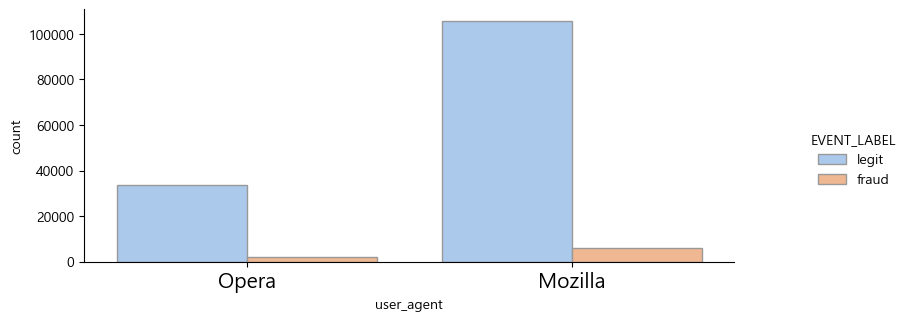

In [35]:
sns.catplot(x="user_agent", hue="EVENT_LABEL", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)

User agent(인터넷 브라우저 사용환경)에 따른 사기거래율 비교한 결과, Mozilla 환경에서 조금 더 사기거래가 발생하는 것을 알 수 있다

In [36]:
cat_val='user_agent'

df_tran = pd.DataFrame(df.groupby([cat_val, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head(5)

df_pivot = pd.pivot_table(df_tran,                  
                      index = cat_val,              
                      columns = 'EVENT_LABEL',      
                      values = 'EVENT_TIMESTAMP')  

df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,user_agent,fraud,legit,ratio
0,Mozilla,6121,105492,5.5
1,Opera,1883,33504,5.3


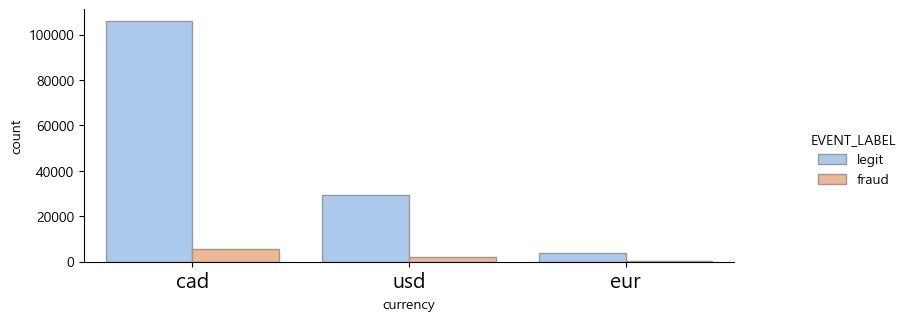

In [38]:
sns.catplot(x="currency", hue="EVENT_LABEL", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)

currency(거래 통화)에 따른 사기거래율 비교한 결과, cad가 가장 사기가 많이 발생하는 것을 확인할 수 있다

In [39]:
cat_val='currency'

df_tran = pd.DataFrame(df.groupby([cat_val, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head(5)

df_pivot = pd.pivot_table(df_tran,                  
                      index = cat_val,              
                      columns = 'EVENT_LABEL',      
                      values = 'EVENT_TIMESTAMP')  

df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,currency,fraud,legit,ratio
0,cad,5674,105869,5.1
1,eur,443,3863,10.3
2,usd,1887,29264,6.1


위의 도수분포표에서 확인한 결과, 사기 거래 수는 cad가 가장 높지만 eur은 비교적 거래가 적지만 사기거래율은 가장 높은 것을 확인할 수 있다

## ML 활용 사기 거래 예측

In [12]:
df['EVENT_LABEL']=np.where(df['EVENT_LABEL']=='fraud', 1, 0)
df['EVENT_LABEL'].value_counts()

0    138996
1      8004
Name: EVENT_LABEL, dtype: int64

Train/Test data에는 문자(str)형태로 이루어진 데이터를 Input 할 수 없기 때문에 Model에서 이해할 수 있는 1, 0으로 Target Data를 변경해준다

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df.drop(['EVENT_TIMESTAMP','EVENT_LABEL', 'transaction_amt_gp'], axis=1)
Y=df['EVENT_LABEL']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(102900, 24)
(102900,)
(44100, 24)
(44100,)


- 보통 데이터 행의 개수와 비슷한 차원이 있는 컬럼은 제거하고 모델링 하는 것이 좋다. 예를 들어, id 같은 것들. 각각의 값이 전부 유니크하면 제거한다

- 새로 만든 파생변수나 기존 컬럼과 동일한 의미의 컬럼들도 제거한다

- 범주형 변수의 값이 3-4개가 적당하고 20개가 넘는 변수는 보통 삭제하고 모델링하는게 좋은데, 처음에는 어떤 변수가 중요한지 모르니 일단 전부 투입시키고 하는게 좋다. 이러한 경우, 범주형 변수들을 인코딩 하면 차원이 워낙 많다보니까 오류 방지 차원에서 train과 test의 값을 합쳐서 만들고 fit 시켜줘야한다

- 분석 시간이 많다 = 범주형 변수들을 하나하나 제거해보면서 모델링

- 분석 시간이 없다 = 효율성을 위해 train과 test의 값을 한번에 fit해서 모델링

In [14]:
categoical_list.remove('EVENT_LABEL')
categoical_list.remove('EVENT_TIMESTAMP')

모델링에 사용하지 않을 범주형 변수는 리스트에서 제외한다  

In [15]:
from sklearn.preprocessing import LabelEncoder

for col in categoical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

ip_address
user_agent
email_domain
phone_number
billing_city
billing_state
currency
cvv
signature_image
transaction_type
transaction_env
applicant_name
billing_address
merchant_id
locale
tranaction_initiate


범주형 변수는 One-hot-encoding 또는 Label-encoding을 통해 숫자형 변수로 변경해야한다. One-hot-encoding은 차원이 많은 변수에는 적절하지 않고, Label-encoding은 회귀관련 알고리즘에서는 사용이 어렵다. 해당 데이터는 차원이 많은 변수가 있으며 분류분석이기 때문에 Label-encoding을 사용한다

In [44]:
x_train[categoical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
43776,8623,0,309,11029,4545,43,0,22,3,8,3,48989,55316,88817,82,7
82596,2079,0,4019,5867,1224,4,0,22,3,5,22,81389,96634,136941,152,24
112312,1074,0,1843,8065,2228,6,0,23,21,6,5,17881,18329,39995,57,15


In [45]:
x_test[categoical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
126812,10814,1,1082,2940,4327,46,0,22,8,13,6,49157,7997,122966,164,11
22846,10637,0,5392,207,2963,28,0,17,8,25,6,29598,104952,7199,157,14
119371,11557,0,1100,2067,1790,42,0,20,5,23,3,16444,30899,5727,131,0


In [16]:
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(random_state = 2023, max_depth=8, n_estimators=500)
rfc.fit(x_train, y_train)

y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     97297
           1       0.98      0.32      0.48      5603

    accuracy                           0.96    102900
   macro avg       0.97      0.66      0.73    102900
weighted avg       0.96      0.96      0.95    102900

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41699
           1       0.97      0.29      0.45      2401

    accuracy                           0.96     44100
   macro avg       0.97      0.65      0.72     44100
weighted avg       0.96      0.96      0.95     44100



1. precision  

- 사기 거래를 할 것 같은 고객들을 예측한 고객들 중에서 실제로 사기 거래를 한 고객의 확률

- 장점 : 최대한 많은 사기 거래 고객들을 후보리스트로 만들어서 관리가 가능하며, 고객 방어가 가능하다

- 단점 : 실제로 그렇지 않은 고객들이 포함될 수 있다.


2. recall  

- 실제로 사기 거래를 한 고객들중에서 사기 거래를 할 것 같은 고객들 중에서 예측을 맞춘 확률

- 장점 : 실제로 사기 거래를 할것같은 고객들만 관리할 수 있다.

- 단점 : 사기 거래 고객들이 적어서 모수가 작아지기 때문에 고객 탈퇴가 늘어날 우려가 있다.  

3. support

- 2401명 중에 728명을 맞춰서 0.29 결과값이 나왔다

In [17]:
pd.Series(y_pred_test).value_counts()

0    43372
1      728
dtype: int64

In [48]:
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:, 1] 
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1] 


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.9467295426944845
roc_score_test : 0.9346405731426466


4. roc_auc_score

- 이진 분류기의 성능을 평가할때 사용하는 지표로 100에 가까울 수록 모델 성능이 좋은 것이라고 할 수 있다.

- 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 것이다.

- 여기서도 train과 test의 roc_score값이 거의 비슷하므로 과적합이 발생하지 않았다고 할 수 있다.

5. predict

- 0과 1로 나누는 것(0.5 이하는 0, 초과는 1)

6. predict_proba

- 0일 확률과 1일 확률로 나누는 것

- [:, 1]의 의미는 전체 고객을 불러오기 위해 행을 :, 사기 거래 고객들의 확률만 추출하기 위해 2번째에 있는 열인 1을 불러온다는 의미이다.

- 1번째에 있는 열은 사기 거래를 하지 않은 고객들의 확률이다.

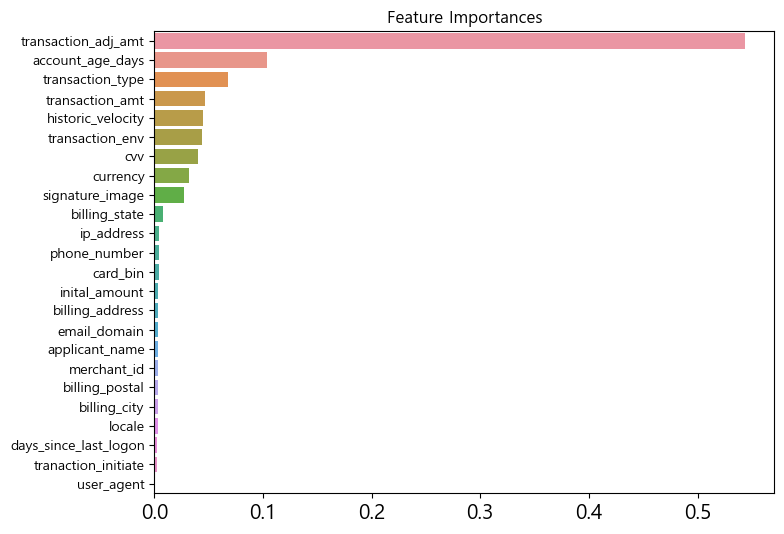

In [49]:
ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

Feature IMP 분석을 통해 중요변수를 파악한다. 위의 상위 변수를 살펴보면, 거래 조정 금액이 사기 거래를 예측하는데 가장 중요한 변수임을 확인할 수 있다. 하지만, billing_state부터 하위 변수들은 예측에 거의 영향을 주지 않는 것을 알 수 있다. 따라서 거래 조정 금액을 주의 깊게 살펴가면서 예측을 진행하는 것이 좋은 판단이다

billing_state부터 하위 변수들은 제거하고 다시 모델링 해보는 것도 좋다

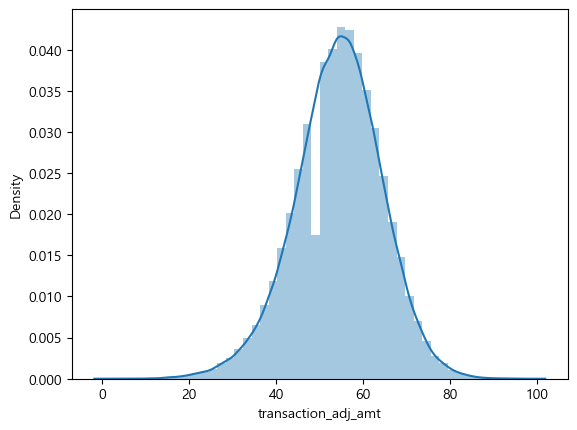

In [18]:
sns.distplot(df['transaction_adj_amt']);

가장 중요한 변수에 대해 상세한 탐색을 실시한다. transaction_adj_amt(거래 조정 금액)의 분포를 확인한다. 한눈에 봐도 정규분포 형태를 띄고 있음을 알 수 있다

In [19]:
import numpy as np
df['transaction_adj_amt_gp'] = np.where (df['transaction_adj_amt'] <= 40, 1, 
                           np.where(df['transaction_adj_amt'] <= 60, 2, 3))

df[['transaction_adj_amt','transaction_adj_amt_gp']]

,transaction_adj_amt,transaction_adj_amt_gp
0,56.0,2
1,48.0,2
2,61.0,3
3,28.0,1
4,66.0,3
...,...,...
149995,57.0,2
149996,61.0,3
149997,48.0,2
149998,59.0,2


40, 60 사이의 값을 평균으로 측정하고 3개의 구간으로 구간화를 진행한다

In [20]:
df.groupby(['transaction_adj_amt_gp', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()

transaction_adj_amt_gp  EVENT_LABEL
1                       0               8072
                        1               4628
2                       0              92394
                        1               3131
3                       0              38530
                        1                245
Name: EVENT_TIMESTAMP, dtype: int64

In [21]:
print("gp1 :", (4628 / (4628+8072)) * 100)
print("gp2 :", (3131 / (3131+92394)) * 100)
print("gp3 :", (245 / (245+38530)) * 100)

gp1 : 36.44094488188976
gp2 : 3.277676001046846
gp3 : 0.6318504190844616


조정된 금액이 작을수록 사기거래 확률이 급격히 상승하는 것을 확인할 수 있다. 가장 중요한 변수임을 알 수 있고, 매우 주의깊게 살펴봐야한다

성과측정은 기본 베이스 코드(위의 전체 코드)를 가지고 익월 데이터를 추가 업로드해서 성과비교가 필요하다. 예를 들어, 위의 데이터로 예측한 사기 거래 고객들을 차단하고 관리해서 익월과 비교하는 것이다.  

ex) 사기 거래 예측 고객 = gp1의 고객들(조정된 금액이 40 이하인 고객들)